# Song lyrics - Part 1: Overview

This is the first of several notebooks examining the song lyrics dataset. This notebook explores some basic properties of the dataset, while also tidying up the data for analysis in the following notebooks.

### Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words
from scipy.stats import linregress

from adjustText import adjust_text

from nlp import tokenize

### Data

The dataset used here is the table of artist/album/song info and lyrics for every song in the core dataset.

In [2]:
df = pd.read_csv('songs.csv', low_memory=False)
df = df[~df.song_darklyrics.isnull()]
df = df[df.song_darklyrics.str.strip().apply(len) > 0]
print(df.columns)

Index(['band_name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label', 'band_years_active',
       'album_name', 'album_type', 'album_year', 'album_review_num',
       'album_review_avg', 'album_url', 'album_reviews_url', 'song_name',
       'song_length', 'song_url', 'song_darklyrics', 'song_darklyrics_url',
       'band_current_label'],
      dtype='object')


### Cleanup song lyrics

There were some issues when parsing lyrics. They are handled here since it isn't quite worth it to rescrape all of darklyrics again with a new scraper.

In [4]:
print('Number of songs', len(df))

Number of songs 60964


In [5]:
# Remove songs that are mostly non-English

min_english = 0.6  # A little higher than 50% to include songs with translations, whose lyrics typically include original and translated text

rows = []
song_words = []
for i, row in df.iterrows():
    text = row.song_darklyrics
    words = tokenize(text)
    english_words = tokenize(text, english_only=True)
    is_english = len(english_words) > min_english * len(words)
    if is_english:
        rows.append(row)
        song_words.append(english_words)
print('Non-English songs removed: ', len(df) - len(rows))
df = pd.DataFrame(rows, columns=df.columns)
df['song_words'] = song_words

Non-English songs removed:  3020


In [6]:
# Remove songs that were copyright claimed

copyrighted = df.song_darklyrics.str.contains('lyrics were removed due to copyright holder\'s request')
print('Songs with lyrics removed: ', len(df[copyrighted]))
df = df[~copyrighted]

Songs with lyrics removed:  66


### Reduced dataset

For lyrical analyses the data is reduced to just a column of lyrics (which will become the feature vector upon some transformation to a quantitative representation) for each song and columns for the most popular genres (the target/label vectors). These are the genres that appear at least once in isolation, i.e. not accompanied by any other genre, and that appear in some minimum percentage of songs. For example, the "black" metal label can appear on bands with or without other genres, but a label like "atmospheric" never appears on its own despite being fairly popular, usually because it is more of an adjective to denote subgenres like atmospheric black metal; thus "black" is included in the reduced label space but "atmospheric" is not. This reduces the genres to a more manageable set: five genres if the minimum occurrence requirement is set to 10%, and thirteen if set to 1%.

A five-genre set would be easier to handle but leaves quite a few holes in the label space, because doom metal, metalcore, folk metal, and many other fairly popular genres are being omitted that may not be covered by any of the five labels. The larger label set covers just about all the most important genres, but because eight of them occur in fewer than 10% of all songs, they will force greater class imbalance which will adversely affect attempts at applying binary classification models later on. For the sake of comparison, both reduced datasets are saved here, but the rest of this exploratory analysis only looks at the 1% dataset, while the 10% dataset is reserved for modeling. Each dataset is saved in its raw form and in a truncated (ML-ready) form containing only the lyrics and genre columns.

In [7]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out


song_genres = df.band_genre.apply(process_genre)
genres = sorted(set(song_genres.sum()))
genre_cols = [f'genre_{genre}' for genre in genres]
for genre, col in zip(genres, genre_cols):
    df[col] = song_genres.apply(lambda x: int(genre in x))

In [8]:
def get_top_genres(data, min_pct):
    isolated = (data.sum(axis=1) == 1)
    isolated_cols = sorted(set(data[isolated].idxmax(axis=1)))
    top_cols = [col for col in isolated_cols if data[col][isolated].mean() >= min_pct]
    top_genres = [re.sub(r"^genre\_", "", col) for col in top_cols]
    return top_genres

In [9]:
top_genres_1pct = get_top_genres(df[genre_cols], 0.01)
print(top_genres_1pct)
df_r = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_1pct)]
df_r.drop(drop_cols, axis=1, inplace=True)
df_r.to_csv('songs-1pct.csv', index=False)

# Only lyrics and genre are relevant for ML later
df_r_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_1pct)
df_r_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_r_ml[top_genres_1pct] = df[[f"genre_{genre}" for genre in top_genres_1pct]].reset_index(drop=True)
df_r_ml.to_csv('songs-ml-1pct.csv', index=False)

['black', 'death', 'deathcore', 'doom', 'folk', 'gothic', 'grindcore', 'heavy', 'metalcore', 'power', 'progressive', 'symphonic', 'thrash']


In [10]:
top_genres_10pct = get_top_genres(df[genre_cols], 0.1)
print(top_genres_10pct)
df_rr = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_10pct)]
df_rr.drop(drop_cols, axis=1, inplace=True)
df_rr.to_csv('songs-10pct.csv', index=False)

# Only lyrics and genre are relevant for ML later
df_rr_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_10pct)
df_rr_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_rr_ml[top_genres_10pct] = df[[f"genre_{genre}" for genre in top_genres_10pct]].reset_index(drop=True)
df_rr_ml.to_csv('songs-ml-10pct.csv', index=False)

['black', 'death', 'heavy', 'power', 'thrash']


# Basic lyrical properties

This section compares looks at word counts and unique word counts, in absolute counts as well as counts per minute, between different songs, albums, bands, and genres. [Part 3](./lyrics2.ipynb) dives much deeper into evaluating lyrical complexity using various lexical diversity measures from the literature.

Song lyrics are tokenized using a custom `tokenize()` function in `nlp.py`.

# Word counts by song

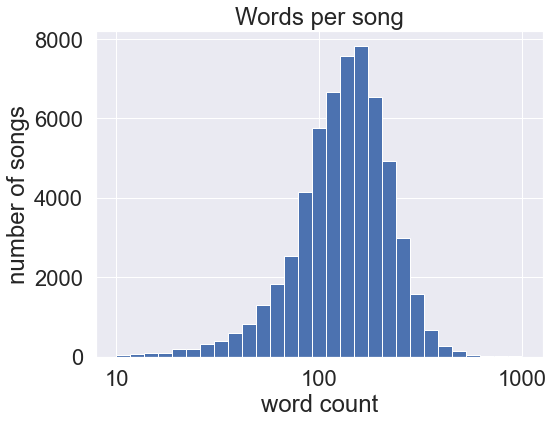

In [11]:
song_word_counts = df_r.song_words.apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
song_word_counts.hist(bins=np.logspace(1, 3, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of songs")
ax.set_title("Words per song")
plt.show()

In [12]:
def to_seconds(data):
    """Convert a time string (MM:ss or HH:MM:ss) to seconds
    """
    out = pd.Series(index=data.index, dtype=int)
    for i, x in data.song_length.items():
        if isinstance(x, str):
            xs = x.split(':')
            if len(xs) < 3:
                xs = [0] + xs
            seconds = int(xs[0]) * 3600 + int(xs[1]) * 60 + int(xs[2])
        else:
            seconds = 0
        out[i] = seconds
    return out

In [13]:
song_seconds = to_seconds(df_r)
song_words_per_second = song_word_counts / song_seconds
song_words_per_second[song_words_per_second == np.inf] = 0

df_r_songs = df_r[['band_name', 'album_name', 'song_name', 'band_genre']].copy()
df_r_songs['song_word_count'] = song_word_counts
df_r_songs['song_seconds'] = song_seconds
df_r_songs['song_words_per_second'] = song_words_per_second

### Songs with highest word counts

The honor of highest word count in a single song goes to the [Bal-Sagoth's "The Obsidian Crown Unbound"](https://youtu.be/xizMG4nI2dk) at over two thousand words. However, most of those words are not sung in the actual song: Bal-Sagoth lyrics typically include the massive collection of narrative text that accompanies their songs. Although the lyrics they sing are still plentiful, there are nowhere near two thousand words spoken in the six-minute symphonic black metal track.

This makes the forty-minute prog metal epic [Crimson by Edge of Sanity](https://youtu.be/St6lJaiHYIc) a better contender for most verbose song. Still, such a claim might be challenged by the fact that the digital edition of the album, which a listener would find on Spotify for instance, divides the single-track album into eight parts. That said, DarkLyrics keeps the original one-track format.

At third place is another multi-part song, [Mirror of Souls](https://youtu.be/y6n1kMsLbc8) by the Christian progressive/power metal group Theocracy. This is less contentious since the official track listing considers this a single track.

In [14]:
df_r_songs.sort_values('song_word_count')[:-10:-1]

,band_name,album_name,song_name,band_genre,song_word_count,song_seconds,song_words_per_second
11862,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,2038,358,5.692737
35657,Edge of Sanity,Crimson,Crimson,Progressive Death Metal,1795,2400,0.747917
100430,Theocracy,Mirror of Souls,Mirror of Souls,Epic Progressive Power Metal,1474,1346,1.095097
11822,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,To Dethrone the Witch-Queen of Mytos K'unn (Th...,Symphonic/Epic Black Metal,1160,405,2.864198
11866,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,1094,262,4.175573
11838,Bal-Sagoth,Battle Magic,Blood Slakes the Sand at the Circus Maximus,Symphonic/Epic Black Metal,1060,533,1.988743
81809,Redemption,Redemption,Something Wicked This Way Comes,Progressive Metal,1010,1466,0.688950
15057,Blind Guardian,A Night at the Opera,And Then There Was Silence,"Speed Metal (early), Power Metal (later)",991,846,1.171395
45056,Green Carnation,"Light of Day, Day of Darkness","Light of Day, Day of Darkness",Death Metal (early); Gothic/Progressive Metal/...,976,3606,0.270660


Sorting by unique word counts shows a similar picture.

### Songs with highest word density

Again "The Obsidian Crown Unbound" tops the charts for highest number of words per second, however at second place, is ["The Ghosts of Christmas Eve"](https://youtu.be/bT4ruFp5U2w), the two-minute intro track to The Christmas Attic by Trans-Siberian Orchestra. Most of the other tracks on this table are short, typically less than a minute.

In [15]:
df_r_songs.sort_values('song_words_per_second')[:-10:-1]

,band_name,album_name,song_name,band_genre,song_word_count,song_seconds,song_words_per_second
11862,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,2038,358,5.692737
103209,Trans-Siberian Orchestra,The Christmas Attic,The Ghosts of Christmas Eve,Orchestral/Progressive Rock/Metal,742,135,5.496296
61709,Macabre,Gloom,I Need to Kill,Thrash/Death Metal/Grindcore,191,36,5.305556
80005,Putrid Pile,Paraphiliac Perversions,Toxic Shock Therapy,Brutal Death Metal,18,4,4.500000
11866,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,1094,262,4.175573
84364,S.O.D.,Bigger than the Devil,Charlie Don't Cheat,Hardcore/Crossover/Thrash Metal,102,25,4.080000
70012,Napalm Death,Scum,You Suffer,"Hardcore Punk (early), Grindcore/Death Metal (...",4,1,4.000000
23586,Circle of Dead Children,Human Harvest,White Trash Headache,"Brutal Death Metal, Grindcore",21,6,3.500000
111972,Wormrot,Dirge,You Suffer but Why Is It My Problem,Grindcore,14,4,3.500000


# Word counts by album

Grouping song lyrics by album shows Blind Guardian's 75-minute [Twilight Orchestra: Legacy of the Dark Lands](https://en.wikipedia.org/wiki/Legacy_of_the_Dark_Lands) coming out on top, even outstripping all of Bal-Sagoth's albums on raw word counts. The list of highest word counts per second mostly consists of Bal-Sagoth and very short albums, with [Waste 'Em All](https://en.wikipedia.org/wiki/Waste_%27Em_All) by Municipal Waste topping the chart. Savatage's [The Wake of Magellan] is the most word-dense album that is anywhere near an hour long.

In [21]:
df_r_albums = pd.concat((
    df_r_songs.groupby(['band_name', 'album_name']).first()[['band_genre']],
    df_r_songs.groupby(['band_name', 'album_name'])[['song_word_count', 'song_seconds']].sum()
), axis=1).reset_index()
df_r_albums.columns = ['band_name', 'album_name', 'band_genre', 'album_word_count', 'album_seconds']
df_r_albums['album_words_per_second'] = df_r_albums.album_word_count / df_r_albums.album_seconds
df_r_albums.loc[df_r_albums['album_words_per_second'] == np.inf, 'album_words_per_second'] = 0

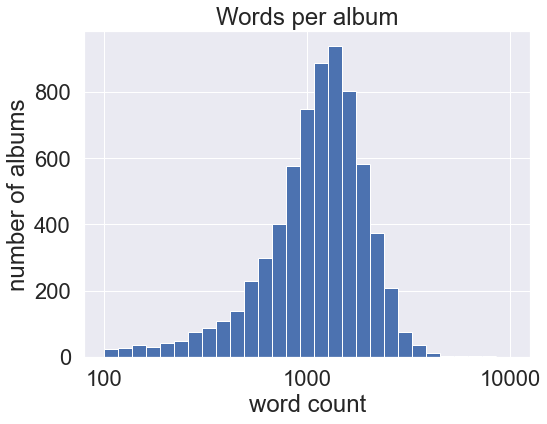

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df_r_albums.album_word_count.hist(bins=np.logspace(2, 4, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of albums")
ax.set_title("Words per album")
plt.show()

### Albums with highest word counts

In [23]:
df_r_albums.sort_values('album_word_count')[:-10:-1]

,band_name,album_name,band_genre,album_word_count,album_seconds,album_words_per_second
881,Blind Guardian,Twilight Orchestra: Legacy of the Dark Lands,"Speed Metal (early), Power Metal (later)",8401,8210,1.023264
644,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,6250,3639,1.717505
643,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,5785,3157,1.832436
5246,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",4966,3218,1.543195
628,Ayreon,The Human Equation,Progressive Metal/Rock,4749,5950,0.798151
6106,Therion,Beloved Antichrist,"Death Metal (early), Symphonic/Operatic Metal ...",4610,9110,0.506037
6238,Trans-Siberian Orchestra,The Christmas Attic,Orchestral/Progressive Rock/Metal,4440,4066,1.091982
871,Blind Guardian,A Night at the Opera,"Speed Metal (early), Power Metal (later)",4382,4024,1.088966
3690,Machine Head,Catharsis,"Groove/Thrash Metal, Nu-Metal",4317,4457,0.968589


### Albums with highest word density

In [24]:
df_r_albums.sort_values('album_words_per_second')[:-10:-1]

,band_name,album_name,band_genre,album_word_count,album_seconds,album_words_per_second
3903,Melvins,Prick,"Sludge Metal, Various",480,257,1.867704
643,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,5785,3157,1.832436
4138,Municipal Waste,Waste 'Em All,Thrash Metal/Crossover,1472,848,1.735849
644,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,6250,3639,1.717505
4551,Origin,Informis Infinitas Inhumanitas,Technical Brutal Death Metal,2767,1712,1.616238
428,Archspire,Relentless Mutation,Technical Death Metal,2950,1837,1.605879
3404,Korpiklaani,Noita,Folk Metal,282,178,1.584270
5246,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",4966,3218,1.543195
4280,Nekrogoblikon,Heavy Meta,Melodic Death/Folk Metal,3223,2151,1.498373


In [46]:
df_r_albums.sort_values('album_words_per_second')[:10]

,band_name,album_name,band_genre,album_word_count,album_seconds,album_words_per_second
5656,Stam1na,SLK,Progressive/Thrash/Heavy Metal,1,168,0.005952
3423,Krallice,Krallice,Avant-garde Black Metal,41,3088,0.013277
1538,Darkspace,Dark Space III I,Atmospheric Black Metal/Ambient,16,1104,0.014493
6483,Versailles,Versailles,Symphonic/Neoclassical Power Metal,2,95,0.021053
934,Boris,Boris at Last - Feedbacker,Various,55,2548,0.021586
3666,Lustre,Wonder,Atmospheric Black Metal/Ambient,25,1102,0.022686
4191,Nadja,Skin Turns to Glass,Ambient Drone/Doom Metal,46,1819,0.025289
3441,Krieg,Blue Miasma,Black Metal,7,236,0.029661
3664,Lustre,Night Spirit,Atmospheric Black Metal/Ambient,73,2460,0.029675
4193,Nadja,Touched,Ambient Drone/Doom Metal,78,2557,0.030504


# Word counts by band

Surprisingly, Bal-Sagoth's inflated lyric counts do not matter much when comparing entire bands, perhaps due to how short their discography is. The bands with the highest word counts typically have massive discographies, and are usually power metal or heavy metal bands. Again, thrash and grindcore bands with short songs comprise most of the highest words-per-second list.

In [25]:
df_r_bands = pd.concat((
    df_r_songs.groupby('band_name').first()['band_genre'],
    df_r_songs.groupby('band_name')[['song_word_count', 'song_seconds']].sum()
), axis=1).reset_index()
df_r_bands.columns = ['band_name', 'band_genre', 'band_word_count', 'band_seconds']
df_r_bands['band_words_per_second'] = df_r_bands.band_word_count / df_r_bands.band_seconds
df_r_bands.loc[df_r_bands['band_words_per_second'] == np.inf, 'band_words_per_second'] = 0

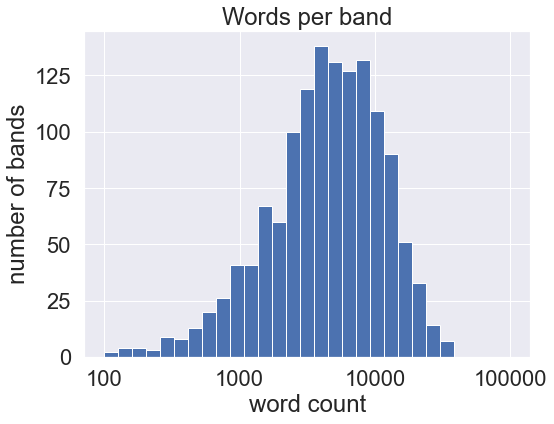

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df_r_bands.band_word_count.hist(bins=np.logspace(2, 5, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of bands")
ax.set_title("Words per band")
plt.show()

### Bands with highest word counts

In [27]:
df_r_bands.sort_values('band_word_count')[:-10:-1]

,band_name,band_genre,band_word_count,band_seconds,band_words_per_second
281,Cradle of Filth,"Death Metal (early), Symphonic Black Metal (mi...",37366,43977,0.849671
1037,Saxon,"NWOBHM, Heavy Metal",34921,53755,0.649633
181,Blind Guardian,"Speed Metal (early), Power Metal (later)",33112,38090,0.869310
649,Iron Maiden,"Heavy Metal, NWOBHM",33021,52673,0.626906
970,Rage,Heavy/Speed/Power Metal,32663,56064,0.582602
913,Overkill,Thrash Metal; Thrash/Groove Metal,31268,47540,0.657720
578,Helloween,Power/Speed Metal,31185,48991,0.636545
1136,Tankard,Thrash Metal,28680,38493,0.745071
663,Judas Priest,Heavy Metal,28488,51177,0.556656


### Bands with highest word density

In [28]:
df_r_bands.sort_values('band_words_per_second')[:-10:-1]

,band_name,band_genre,band_word_count,band_seconds,band_words_per_second
89,Archspire,Technical Death Metal,6872,5189,1.324340
828,Municipal Waste,Thrash Metal/Crossover,9807,7479,1.311272
28,Acrania,Brutal Deathcore,2106,1674,1.258065
187,Blood Freak,Death Metal/Grindcore,5582,4447,1.255228
1151,The Berzerker,Industrial Death Metal/Grindcore,10060,8290,1.213510
132,Bal-Sagoth,Symphonic/Epic Black Metal,19223,16021,1.199863
75,Animosity,Death Metal/Metalcore/Grindcore,5522,4677,1.180671
205,Brujeria,Death Metal/Grindcore,1832,1640,1.117073
17,Absurd,"Black Metal/RAC, Pagan Black Metal",135,122,1.106557


In [45]:
df_r_bands.sort_values('band_words_per_second')[:10]

,band_name,band_genre,band_word_count,band_seconds,band_words_per_second
740,Lustre,Atmospheric Black Metal/Ambient,180,5966,0.030171
838,Nadja,Ambient Drone/Doom Metal,607,14434,0.042053
407,Dragged into Sunlight,Blackened Death/Doom Metal,103,2085,0.049400
879,Nortt,Black/Funeral Doom Metal,31,499,0.062124
601,Hypothermia,Black Metal (early); Post-Metal/Rock (later),148,2167,0.068297
803,Monolithe,Funeral Doom Metal (early); Melodic Death/Doom...,764,11065,0.069047
695,Krieg,Black Metal,45,623,0.072231
1239,Ufomammut,Psychedelic Sludge/Stoner/Doom Metal,797,10233,0.077885
802,Monarch,Sludge/Drone/Doom Metal,367,4658,0.078789
269,Comatose Vigil,Funeral Doom Metal,409,5165,0.079187


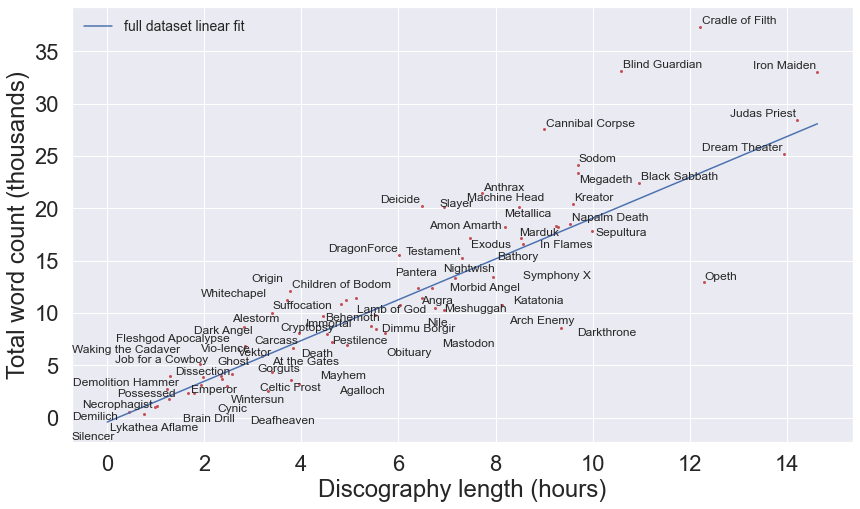

In [29]:
min_reviews = 20

bands_popular = sorted(set(df_r[df_r['album_review_num'] > min_reviews].band_name))
df_r_bands_popular = df_r_bands[df_r_bands.band_name.isin(bands_popular)].set_index('band_name', drop=True)

plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for band, row in df_r_bands_popular.iterrows():
    x = row['band_seconds'] / 3600.0
    y = row['band_word_count'] / 1000.0
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.')

res = linregress(df_r_bands.band_seconds / 3600.0, df_r_bands.band_word_count / 1000.0)
xline = np.linspace(0, df_r_bands_popular.band_seconds.max() / 3600.0)
yline = xline * res.slope + res.intercept
plt.plot(xline, yline, label='full dataset linear fit')

texts = []
for x, y, band in zip(xlist, ylist, df_r_bands_popular.index):
    texts.append(plt.text(x, y, band, fontsize=12))
adjust_text(texts)

plt.xlabel('Discography length (hours)')
plt.ylabel('Total word count (thousands)')
plt.legend(fontsize=14)
plt.show()

# Word counts by genre

Although there are some noticeable trends in the word counts of genres, overall the distributions of word counts and song lengths per genre are quite broad, perhaps overlapping too much to be of any use for predictions later on.

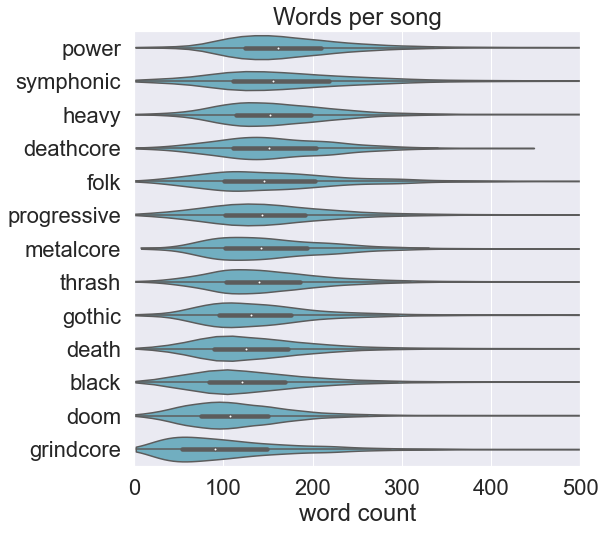

In [37]:
df_genre_songs = df_r[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_1pct]].copy()
df_genre_songs['song_word_count'] = df_r_songs.song_word_count
df_genre_songs['song_seconds'] = df_r_songs.song_seconds

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1]
    violindata.append((genre, df_genre['song_word_count']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim(0, 500)
ax.set_title("Words per song")
ax.set_xlabel("word count")
plt.show()

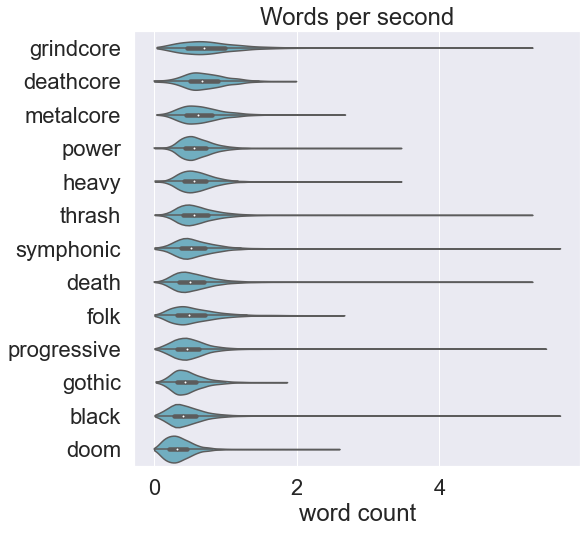

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1].copy()
    df_genre['song_words_per_second'] = df_genre['song_word_count'] / df_genre['song_seconds']
    df_genre.loc[df_genre['song_words_per_second'] == np.inf, 'song_words_per_second'] = 0
    violindata.append((genre, df_genre['song_words_per_second']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_title("Words per second")
ax.set_xlabel("word count")
plt.show()

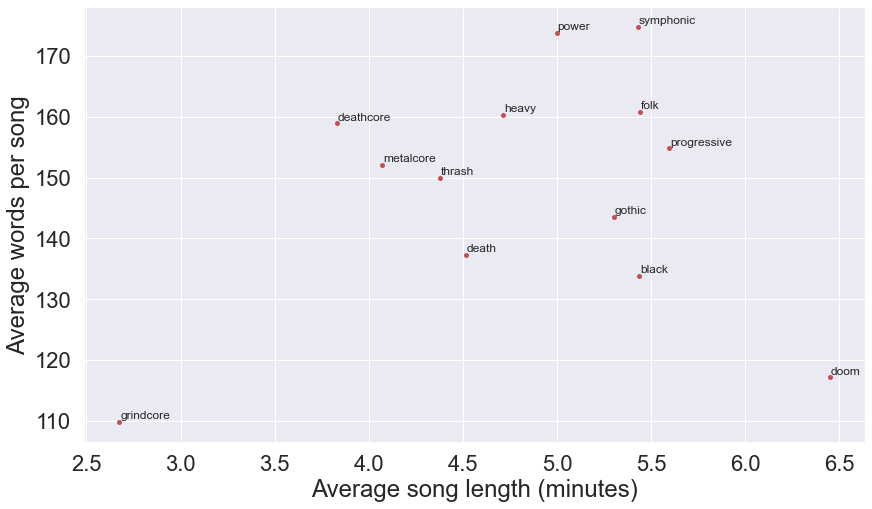

In [39]:
plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1].copy()
    x = df_genre['song_seconds'].mean() / 60.0
    y = df_genre['song_word_count'].mean()
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.', ms=10, label=genre)
texts = []
for x, y, genre in zip(xlist, ylist, top_genres_1pct):
    texts.append(plt.text(x, y , genre, fontsize=12))
adjust_text(texts)
plt.xlabel('Average song length (minutes)')
plt.ylabel('Average words per song')
plt.show()

### 95% contours for top-five genres

In [42]:
df_genre_10pct_songs = df_rr[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_10pct]].copy()
df_genre_10pct_songs['song_word_count'] = df_rr.song_words.apply(len)
df_genre_10pct_songs['song_seconds'] = to_seconds(df_rr)

C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


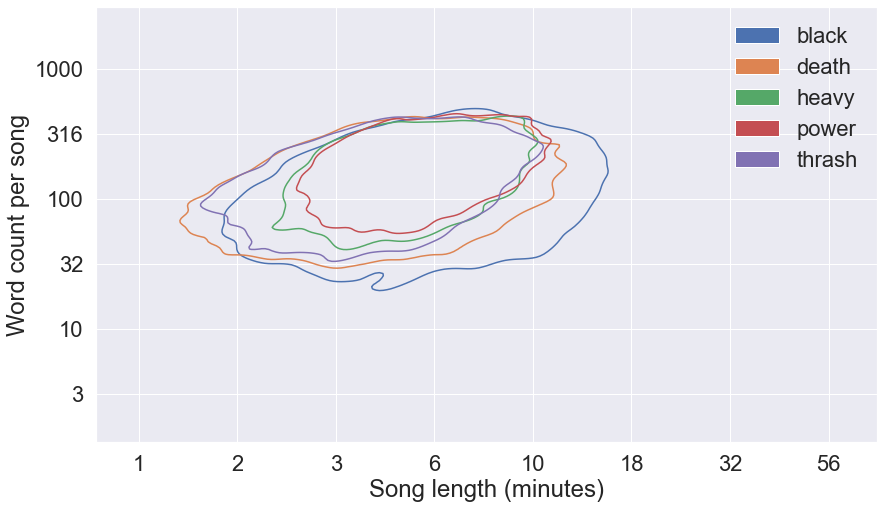

In [43]:
plt.figure(figsize=(14, 8))
ax = plt.gca()
colors = sns.color_palette()
handles = []
for i, genre in enumerate(top_genres_10pct):
    df_genre = df_genre_10pct_songs[df_genre_10pct_songs['genre_' + genre] == 1].copy()
    x = np.log10(df_genre['song_seconds'] / 60.0)
    y = np.log10(df_genre['song_word_count'])
    pos = (x > 0) & (y > 0)
    sns.kdeplot(x=x[pos], y=y[pos], levels=[0.05, 1], ax=ax)
    handles.append(Patch(facecolor=colors[i % len(colors)], label=genre))
ax.set_xticklabels([f"{10**tick:.0f}" for tick in ax.get_xticks()])
ax.set_yticklabels([f"{10**tick:.0f}" for tick in ax.get_yticks()])
ax.set_xlabel('Song length (minutes)')
ax.set_ylabel('Word count per song')
ax.legend(handles=handles)
plt.show()